Imports & Load Data from MongoDB

In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import pymongo


Connect to MongoDB & Load Clean Data

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["climate_db"]
collection = db["temperatures_clean"]

data = pd.DataFrame(list(collection.find()))
data = data.drop(columns=["_id"])   

data.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
0,1750-06-01,14.913,1.181,Århus,Denmark,57.05,10.33,1750,6
1,1751-04-01,5.267,0.850,Århus,Denmark,57.05,10.33,1751,4
2,1752-12-01,2.242,1.175,Århus,Denmark,57.05,10.33,1752,12
3,1753-10-01,9.529,2.690,Århus,Denmark,57.05,10.33,1753,10
4,1754-08-01,15.537,5.868,Århus,Denmark,57.05,10.33,1754,8


Encode Categorical Columns

In [3]:
le_city = LabelEncoder()
le_country = LabelEncoder()

data["City_encoded"] = le_city.fit_transform(data["City"])
data["Country_encoded"] = le_country.fit_transform(data["Country"])


Define Features & Target

In [4]:
X = data[["year", "month", "Latitude", "Longitude", "City_encoded", "Country_encoded"]]
y = data["AverageTemperature"]

Train/Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Linear Regression

In [6]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

pred_lr = model_lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, pred_lr)))


Linear Regression R²: 0.2754645323823579
Linear Regression RMSE: 8.851419658456154


Logistic Regression

In [18]:
y_train_bin = (y_train > y_train.median()).astype(int)

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train_bin)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Polynomial Regression (Degree 2)

In [7]:
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

pred_poly = poly_model.predict(X_poly_test)

print("Polynomial Regression R²:", r2_score(y_test, pred_poly))
print("Polynomial Regression RMSE:", np.sqrt(mean_squared_error(y_test, pred_poly)))


Polynomial Regression R²: 0.722263338999416
Polynomial Regression RMSE: 5.480241684699622


Random Forest Regressor

In [9]:
rf_model = RandomForestRegressor(
    n_estimators=80,       # 80–100 is often enough
    max_depth=15,
    min_samples_split=5,
    n_jobs=-1,             # Use all CPU cores
    random_state=42
    
)
rf_model.fit(X_train, y_train) 
pred_rf = rf_model.predict(X_test)
print("Random Forest R²:", r2_score(y_test, pred_rf)) 
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))

Random Forest R²: 0.9807835127286173
Random Forest RMSE: 1.441518127202445


XGBoost Regressor

In [10]:
xgb_model = XGBRegressor(
    n_estimators=150,            
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42,
    tree_method='hist',         
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

pred_xgb = xgb_model.predict(X_test)

print("XGBoost R²:", r2_score(y_test, pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, pred_xgb)))

XGBoost R²: 0.9597549062574326
XGBoost RMSE: 2.0861214010002977


Prediction Function

In [19]:
def predict_temperature(year, month, city, country, lat, lon):
    city_code = le_city.transform([city])[0]
    country_code = le_country.transform([country])[0]

    X_new = np.array([[year, month, lat, lon, city_code, country_code]])

    preds = {
        "Linear Regression": model_lr.predict(X_new)[0],
        "Polynomial Regression": poly_model.predict(poly.transform(X_new))[0],
        "Random Forest": rf_model.predict(X_new)[0],
        "XGBoost": xgb_model.predict(X_new)[0]
    }

    # Scale X_new for logistic regression
    X_new_scaled = scaler.transform(X_new)
    log_pred = log_model.predict(X_new_scaled)[0]
    preds["Logistic Regression (Above Median)"] = bool(log_pred)

    return preds


Example Prediction

In [20]:
result = predict_temperature(
    year=2027,
    month=6,
    city="Karachi",
    country="Pakistan",
    lat=24.8607,
    lon=67.0011
)

result


c:\Users\SD\climate_project\climate_venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\SD\climate_project\climate_venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\SD\climate_project\climate_venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\SD\climate_project\climate_venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'Linear Regression': np.float64(19.001855508262004),
 'Polynomial Regression': np.float64(29.187364170961132),
 'Random Forest': np.float64(30.5695415767125),
 'XGBoost': np.float32(29.836195),
 'Logistic Regression (Above Median)': True}

Compare Predictions

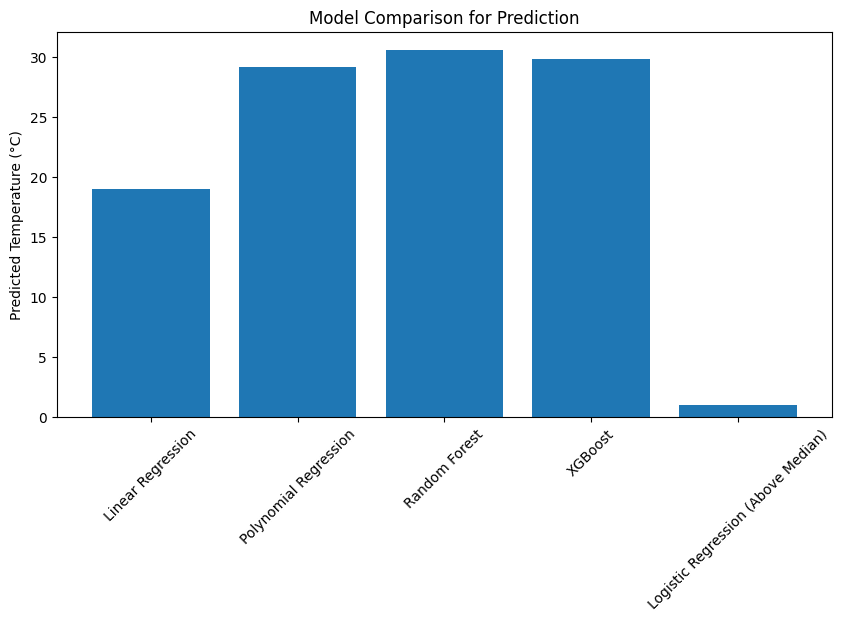

In [21]:
models = list(result.keys())
values = list(result.values())

plt.figure(figsize=(10,5))
plt.bar(models, values)
plt.xticks(rotation=45)
plt.ylabel("Predicted Temperature (°C)")
plt.title("Model Comparison for Prediction")
plt.show()
